# Notas de Gonche

In [1]:
from simulator.population_networks.generic.population_network_from_hdx import PopulationNetworkFromHDX
from simulator.disasters.specific.drill_earthquake import DrillEarthQuake
from simulator.population_networks.specific.panama_costarica import PanamaCostaRica


In [2]:
population_network = PanamaCostaRica()
disaster = DrillEarthQuake()

In [3]:
from os.path import join
import simulator.constants as con
import geopandas as gpd

world_pop_density_file = join(con.DATA_FOLDER,"costa_rica-panama/pd_2020_1km_ASCII_XYZ.csv")
populated_places_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_populated_places_points_shp")
road_lines_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_roads_lines_shp")
building_polygons_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_buildings_polygons_shp")


In [6]:
import numpy as np
import simulator.constants as con 
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import haversine_distances
from simulator.utils.geometric import haversine
from math import radians

from shapely.geometry import LineString, Point

import simulator.utils.geometric as geo_fun

In [4]:
nodes = population_network.nodes

   Reading nodes from Cache


In [7]:


# Modified Local Sensitive Hashing
# Extracts City Centers
city_centers = geo_fun.extract_city_centers_from_nodes(nodes)

# Projects to manipulation
city_centers[con.GEOMETRY] = city_centers[con.GEOMETRY].to_crs(con.MANIPULATION_PROJECTION) 
city_centers["x"] = city_centers[con.GEOMETRY].x
city_centers["y"] = city_centers[con.GEOMETRY].y


# Extracts possible neighbors
dist_meters = con.MAX_DISTANCE_BETWEEN_ADJACENT_CITIES_KM*1000

dfs = []
for _, row in city_centers.iterrows():
    filtered = city_centers[(np.abs(city_centers.x - row.x) < dist_meters) & (np.abs(city_centers.y - row.y) < dist_meters)]

    dfs.append(pd.DataFrame({con.NODE_ID1 : row[con.ID], con.NODE_ID2 : filtered[con.ID]}))


edges = pd.concat(dfs, ignore_index=True)
edges = edges[edges[con.NODE_ID1] > edges[con.NODE_ID2]]


# Corrects distance

nodes.index = nodes[con.ID]

edges = edges.merge(nodes[[con.ID, con.LON, con.LAT]].rename(columns={con.ID : con.NODE_ID1})).rename(columns = {con.LAT : "lat_x", con.LON : "lon_x"})
edges = edges.merge(nodes[[con.ID, con.LON, con.LAT]].rename(columns={con.ID : con.NODE_ID2})).rename(columns = {con.LAT : "lat_y", con.LON : "lon_y"})

edges["lat_x"] = edges["lat_x"].apply(radians)
edges["lon_x"] = edges["lon_x"].apply(radians)
edges["lat_y"] = edges["lat_y"].apply(radians)
edges["lon_y"] = edges["lon_y"].apply(radians)

edges[con.DISTANCE] = edges.apply(lambda row: haversine(row.lon_x, row.lat_x, row.lon_y, row.lat_y, True), axis = 1)

# Filters by actual distance
edges = edges[edges[con.DISTANCE] < con.MAX_DISTANCE_BETWEEN_ADJACENT_CITIES_KM*1000]

# Checks if graph is connected
graph = nx.Graph()
graph.add_nodes_from(nodes[con.ID].values)
graph.add_edges_from(edges.apply(lambda row: (row[con.NODE_ID1], row[con.NODE_ID2]), axis = 1).values)
components = list(nx.connected_components(graph))

print(f"   Total Edges: {edges.shape[0]}")
print(f"   Connected Components: {len(components)}")


# Recovers the lat and lot
edges = edges[[con.NODE_ID1, con.NODE_ID2, con.DISTANCE]].copy()
edges = edges.merge(nodes[[con.ID, con.LON, con.LAT]].rename(columns={con.ID : con.NODE_ID1})).rename(columns = {con.LAT : "lat_x", con.LON : "lon_x"})
edges = edges.merge(nodes[[con.ID, con.LON, con.LAT]].rename(columns={con.ID : con.NODE_ID2})).rename(columns = {con.LAT : "lat_y", con.LON : "lon_y"})


# Creates the line string geometry
edges = gpd.GeoDataFrame( edges, geometry = edges.apply(lambda row : LineString([Point(row.lon_x, row.lat_x), Point(row.lon_y, row.lat_y)]) , axis = 1), crs = con.USUAL_PROJECTION)

# Constant Value
edges[con.VALUE] = 1

edges = edges[[con.NODE_ID1, con.NODE_ID2, con.VALUE, con.GEOMETRY]].copy()

edges



   Total Edges: 1210437
   Connected Components: 1


,node_id1,node_id2,value,geometry
0,Liberia - 0,Filadelfia - 35,1,"LINESTRING (-85.43627 10.63334, -85.55263 10.4..."
1,Santa Cruz - 34,Filadelfia - 35,1,"LINESTRING (-85.58482 10.26153, -85.55263 10.4..."
2,Quebrada Honda - 66,Filadelfia - 35,1,"LINESTRING (-85.29765 10.18758, -85.55263 10.4..."
3,Playa Grande - 108,Filadelfia - 35,1,"LINESTRING (-85.84753 10.33405, -85.55263 10.4..."
4,Hermosa - 134,Filadelfia - 35,1,"LINESTRING (-85.67419 10.57450, -85.55263 10.4..."
...,...,...,...,...
1210432,San José - 5481,Pedro de Cocal - 3489,1,"LINESTRING (-79.10961 8.22821, -79.10202 8.41431)"
1210433,Viveros - 5490,Pedro de Cocal - 3489,1,"LINESTRING (-78.98040 8.48201, -79.10202 8.41431)"
1210434,San Miguel - 4400,San José - 5481,1,"LINESTRING (-78.93705 8.45686, -79.10961 8.22821)"
1210435,Viveros - 5490,San José - 5481,1,"LINESTRING (-78.98040 8.48201, -79.10961 8.22821)"


In [8]:
edges.to_file("temp")

,highway,geometry
0,service,"LINESTRING (-84.14531 9.95885, -84.14520 9.958..."
1,service,"LINESTRING (-84.14514 9.95930, -84.14293 9.959..."
2,secondary,"LINESTRING (-84.09124 9.94787, -84.09146 9.947..."
3,secondary,"LINESTRING (-84.07361 9.91168, -84.07382 9.911..."
4,trunk_link,"LINESTRING (-84.11712 9.94019, -84.11713 9.939..."
...,...,...
231505,unclassified,"MULTILINESTRING ((-82.75171 9.58771, -82.75312..."
231506,unclassified,"MULTILINESTRING ((-82.75171 9.58771, -82.75312..."
231507,unclassified,"MULTILINESTRING ((-82.75977 9.59313, -82.76028..."
231508,unclassified,"MULTILINESTRING ((-82.75977 9.59313, -82.76028..."


In [27]:
# Reads the file
roads = gpd.read_file(road_lines_folder)
roads = roads[["highway", con.GEOMETRY]].copy()

roads = roads[roads.highway != "residential"].copy()


# Simplifies the geometry
roads[con.GEOMETRY] = roads[con.GEOMETRY].to_crs(con.MANIPULATION_PROJECTION)
roads[con.GEOMETRY] = roads[con.GEOMETRY].simplify(con.SIMPLIFICATION_CONSTANTS_METERS)
roads[con.GEOMETRY] = roads[con.GEOMETRY].to_crs(con.USUAL_PROJECTION)


  # Creates Intersection
intersection = roads.sjoin(roads)
# Renames
intersection = intersection.reset_index().rename(columns = {"index" : "index_left"})

# Filters out self intersections
intersection = intersection[intersection.index_left != intersection.index_right]
# Filters out roads without same type
intersection = intersection[intersection.highway_left == intersection.highway_right]


# Create an undirected graph and finds connected components to merge
graph = nx.Graph()
graph.add_nodes_from(roads.index.values)
graph.add_edges_from(intersection.apply(lambda row: (row.index_left, row.index_right), axis = 1).values)
components = list(nx.connected_components(graph))

# Assigns the groups / components
i = 0
dfs = []
for comp in components:
    dfs.append(pd.DataFrame({"group" : i},index = list(comp)))
    i += 1

groups = pd.concat(dfs)
roads["group"] = groups['group']

# Dissolves
roads = roads.dissolve(by="group").reset_index(drop = True)

roads


,geometry,highway
0,"MULTILINESTRING ((-84.14531 9.95885, -84.14288...",service
1,"MULTILINESTRING ((-84.09124 9.94787, -84.09165...",secondary
2,"MULTILINESTRING ((-84.11712 9.94019, -84.11717...",trunk_link
3,"MULTILINESTRING ((-84.11645 9.93860, -84.11657...",trunk_link
4,"LINESTRING (-84.11648 9.93629, -84.11641 9.93624)",trunk_link
...,...,...
60168,"MULTILINESTRING ((-82.82806 8.87898, -82.82830...",unclassified
60169,"MULTILINESTRING ((-82.90541 8.83246, -82.90349...",unclassified
60170,"MULTILINESTRING ((-82.90799 8.44169, -82.90794...",footway
60171,"LINESTRING (-82.90817 8.44242, -82.90773 8.44224)",footway


,node_id1,node_id2,distance,lon_x,lat_x,lon_y,lat_y,geometry
0,Liberia - 0,Filadelfia - 35,24467.461095,-85.436272,10.633340,-85.552632,10.445374,"LINESTRING (-85.43627 10.63334, -85.55263 10.4..."
1,Santa Cruz - 34,Filadelfia - 35,20743.221154,-85.584821,10.261532,-85.552632,10.445374,"LINESTRING (-85.58482 10.26153, -85.55263 10.4..."
2,Playa Grande - 108,Filadelfia - 35,34547.617096,-85.847534,10.334053,-85.552632,10.445374,"LINESTRING (-85.84753 10.33405, -85.55263 10.4..."
3,Hermosa - 134,Filadelfia - 35,19564.543666,-85.674186,10.574502,-85.552632,10.445374,"LINESTRING (-85.67419 10.57450, -85.55263 10.4..."
4,Puerto Culebra - 135,Filadelfia - 35,24520.245350,-85.651037,10.643535,-85.552632,10.445374,"LINESTRING (-85.65104 10.64353, -85.55263 10.4..."
...,...,...,...,...,...,...,...,...
809219,San Miguel - 4400,San José - 5481,31730.353950,-78.937053,8.456862,-79.109605,8.228210,"LINESTRING (-78.93705 8.45686, -79.10961 8.22821)"
809220,Viveros - 5490,San José - 5481,31599.085552,-78.980396,8.482009,-79.109605,8.228210,"LINESTRING (-78.98040 8.48201, -79.10961 8.22821)"
809221,San Miguel - 4400,Saboga - 5483,23283.390263,-78.937053,8.456862,-79.060795,8.626776,"LINESTRING (-78.93705 8.45686, -79.06079 8.62678)"
809222,Viveros - 5490,Saboga - 5483,18365.187016,-78.980396,8.482009,-79.060795,8.626776,"LINESTRING (-78.98040 8.48201, -79.06079 8.62678)"


In [23]:
edges

,node_id1,node_id2,distance,lon_x,lat_x,lon_y,lat_y
0,Liberia - 0,Filadelfia - 35,24467.461095,-85.436272,10.633340,-85.552632,10.445374
1,Santa Cruz - 34,Filadelfia - 35,20743.221154,-85.584821,10.261532,-85.552632,10.445374
2,Playa Grande - 108,Filadelfia - 35,34547.617096,-85.847534,10.334053,-85.552632,10.445374
3,Hermosa - 134,Filadelfia - 35,19564.543666,-85.674186,10.574502,-85.552632,10.445374
4,Puerto Culebra - 135,Filadelfia - 35,24520.245350,-85.651037,10.643535,-85.552632,10.445374
...,...,...,...,...,...,...,...
809219,San Ignacio de Tupile - 5687,Irgandí - 5686,17135.143431,-78.154765,9.295159,-78.305628,9.334949
809220,Maguebgandi - 4286,Irgandí - 5686,12706.862315,-78.410236,9.383997,-78.305628,9.334949
809221,Ukupa - 5685,Irgandí - 5686,3710.547231,-78.331799,9.356085,-78.305628,9.334949
809222,San Ignacio de Tupile - 5687,Playón Chico - 4287,8741.720452,-78.154765,9.295159,-78.232620,9.311818


In [25]:

# Trims
new_geo = []

percentage_print = 0.1
print_every = int(np.floor(percentage_print*edges.shape[0]))

entire_geometry = roads.iloc[0][con.GEOMETRY]

print("Trimming Roads") # Apply generates out of memory
for i, edge_row in edges.iterrows():

    # Trims
    new_geo.append(geo_fun.trim_road(entire_geometry, edge_row.lon_x, edge_row.lat_x, edge_row.lon_y, edge_row.lat_y))

    print(i)
    if i % print_every == 0:
        print(f"   Progress: {np.round(100*i/edges.shape[0])}%")

print("Done trimming")

Trimming Roads
0
   Progress: 0.0%
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [24]:
from shapely.geometry import Polygon, Point

def trim_road(geometry, lon_1, lat_1, lon_2, lat_2):
    '''
    Method that trims the given geometry to the endpoints given.
    This method is design to adjust road line strings so that they don't exceed the given endpoints. 
    '''
    # Width of square in kilometer
    kms_width = 1000

    # Extract Normal Vector
    if lon_1 == lon_2:
        N1 = 1
        N2 = 0
    else:
        N2 = -1
        N1 = (lat_2 - lat_1) / (lon_2 - lon_1)

    # Normalizes
    length = np.sqrt(N1**2+N2**2)
    N1 /= length
    N2 /= length

    # Multiplies by size
    N1 *= kms_width/111.32 # 111.32 km is one longitude/latitude near the equator
    N2 *= kms_width/111.32 # 111.32 km is one longitude/latitude near the equator

    # Location 1 point in perpendicular line
    l1_1 = (lon_1 + N1, lat_1 + N2)
    l1_2 = (lon_1 - N1, lat_1 - N2)

    # Location 2 point in perpendicular line
    l2_1 = (lon_2 + N1, lat_2 + N2)
    l2_2 = (lon_2 - N1, lat_2 - N2)

    points = [l1_1, l1_2, l2_2, l2_1]

    # Create a polygon
    #polygon = Polygon(points)

    # Create a GeoDataFrame with the polygon
    return geometry.clip_by_rect(-85.552632, 10.445374, -85.436272, 10.633340	)

In [32]:
# Starts Simulation
# Assigns id as index for quick search
population_network.nodes.index = population_network.nodes[con.ID]
population_network.edges.index = population_network.edges.apply(lambda row:  f"{row[NODE_ID1]}-{row[NODE_ID2]}", axis = 1)



# Percentage of Population with coverage
population_with_coverage = 0.3

total_elements = int(np.round(population_with_coverage*population_network.nodes[con.POPULATION].sum()))

# Creates ID
positions = pd.DataFrame({con.ID : [i for i in range(total_elements)]})

# Assigns Nodes
positions[LOCATION] = NODE

positions[LOCATION_ID] = np.random.choice(population_network.nodes[con.ID].values, total_elements,
              p=population_network.nodes[con.POPULATION].values / population_network.nodes[con.POPULATION].sum())


# Initializes the forces
population_network.nodes[ATTRACTIVE_FORCE] = population_network.nodes[con.POPULATION].values / population_network.nodes[con.POPULATION].sum()
population_network.nodes[REPELLING_FORCE] = 0



In [39]:
location_id = "Chivo Chivo - 5711"
# Creates the adjacency data frames

neighbors = set(population_network.edges.loc[population_network.edges[NODE_ID1] == location_id, NODE_ID2].values)
neighbors = neighbors.union(population_network.edges.loc[population_network.edges[NODE_ID2] == location_id, NODE_ID1].values)
#temp = population_network.loc[(population_network.edges[NODE_ID1])]
neighbors

set()

In [42]:
population_network.edges[[NODE_ID1, NODE_ID2]].to_csv('temp.csv', index = False)

In [36]:

# Step


df = positions.loc[positions[LOCATION_ID] == "Chivo Chivo - 5711"]
df


,id,location,location_id
94,94,node,Chivo Chivo - 5711
137,137,node,Chivo Chivo - 5711
255,255,node,Chivo Chivo - 5711
277,277,node,Chivo Chivo - 5711
373,373,node,Chivo Chivo - 5711
...,...,...,...
3314175,3314175,node,Chivo Chivo - 5711
3314199,3314199,node,Chivo Chivo - 5711
3314216,3314216,node,Chivo Chivo - 5711
3314233,3314233,node,Chivo Chivo - 5711


In [14]:
import geopandas as gpd

from os.path import join
import simulator.constants as con

world_pop_density_file = join(con.DATA_FOLDER,"costa_rica-panama/pd_2020_1km_ASCII_XYZ.csv")
populated_places_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_populated_places_points_shp")
road_lines_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_roads_lines_shp")
building_polygons_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_buildings_polygons_shp")

import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import networkx as nx

from simulator.population_networks.abstract.population_network import PopulationNetwork
import simulator.constants as con
import simulator.utils.geometric as geo_fun

from shapely.geometry import Point


In [15]:
populated_places = gpd.read_file(populated_places_folder)

In [19]:
populated_places

,osm_id,name,population,source,place,is_in,geometry
0,1.838030e+08,Liberia,46000,NaN,city,NaN,POINT (-85.43627 10.63334)
1,1.840328e+08,Tilarán,9000,NaN,town,"Tilarán, Guanacaste",POINT (-84.96726 10.47098)
2,1.840978e+08,La Fortuna,17000,NaN,village,NaN,POINT (-84.64444 10.47168)
3,1.854893e+08,Limón,70000,NaN,city,NaN,POINT (-83.03031 9.99356)
4,1.855355e+08,Sixaola,NaN,NaN,village,NaN,POINT (-82.61457 9.50542)
...,...,...,...,...,...,...,...
6550,1.067682e+10,Bajo La Concepción,NaN,NaN,hamlet,NaN,POINT (-81.31209 8.26600)
6551,1.067682e+10,Alto de La Palma,NaN,NaN,hamlet,NaN,POINT (-81.36823 8.24656)
6552,1.067682e+10,Agua Viva,NaN,NaN,hamlet,NaN,POINT (-81.29422 8.21721)
6553,1.068311e+10,El Bongo,172,NaN,hamlet,NaN,POINT (-80.46281 7.92044)


In [20]:
populated_places.dropna(subset = "name").reset_index(drop = True)

,osm_id,name,population,source,place,is_in,geometry
0,1.838030e+08,Liberia,46000,NaN,city,NaN,POINT (-85.43627 10.63334)
1,1.840328e+08,Tilarán,9000,NaN,town,"Tilarán, Guanacaste",POINT (-84.96726 10.47098)
2,1.840978e+08,La Fortuna,17000,NaN,village,NaN,POINT (-84.64444 10.47168)
3,1.854893e+08,Limón,70000,NaN,city,NaN,POINT (-83.03031 9.99356)
4,1.855355e+08,Sixaola,NaN,NaN,village,NaN,POINT (-82.61457 9.50542)
...,...,...,...,...,...,...,...
6440,1.067682e+10,Bajo La Concepción,NaN,NaN,hamlet,NaN,POINT (-81.31209 8.26600)
6441,1.067682e+10,Alto de La Palma,NaN,NaN,hamlet,NaN,POINT (-81.36823 8.24656)
6442,1.067682e+10,Agua Viva,NaN,NaN,hamlet,NaN,POINT (-81.29422 8.21721)
6443,1.068311e+10,El Bongo,172,NaN,hamlet,NaN,POINT (-80.46281 7.92044)


In [45]:
# Reads the file
roads = gpd.read_file(road_lines_folder)
roads = roads[["highway", con.GEOMETRY]].copy()


# Simplifies the geometry
roads[con.GEOMETRY] = roads[con.GEOMETRY].to_crs(con.MANIPULATION_PROJECTION)
roads[con.GEOMETRY] = roads[con.GEOMETRY].simplify(con.SIMPLIFICATION_CONSTANTS_METERS)
roads[con.GEOMETRY] = roads[con.GEOMETRY].to_crs(con.USUAL_PROJECTION)

# Creates Intersection
intersection = roads.sjoin(roads)
# Renames
intersection = intersection.reset_index().rename(columns = {"index" : "index_left"})

# Filters out self intersections
intersection = intersection[intersection.index_left != intersection.index_right]
# Filters out roads without same type
intersection = intersection[intersection.highway_left == intersection.highway_right]


# Create an undirected graph and finds connected components to merge
graph = nx.Graph()
graph.add_nodes_from(roads.index.values)
graph.add_edges_from(intersection.apply(lambda row: (row.index_left, row.index_right), axis = 1).values)
components = list(nx.connected_components(graph))

# Assigns the groups / components
i = 0
dfs = []
for comp in components:
    dfs.append(pd.DataFrame({"group" : i},index = list(comp)))
    i += 1

groups = pd.concat(dfs)
roads["group"] = groups['group']

# Dissolves
roads = roads.dissolve(by="group").reset_index(drop = True)



,id,lat,lon,population,geometry,attractive_force,repelling_force
id,,,,,,,
Liberia - 0,Liberia - 0,10.633340,-85.436272,58725.820929,"MULTIPOLYGON (((-85.48115 10.56953, -85.48118 ...",0.005316,0
Tilarán - 1,Tilarán - 1,10.470980,-84.967260,10366.156730,"MULTIPOLYGON (((-84.96930 10.46810, -84.96943 ...",0.000938,0
La Fortuna - 2,La Fortuna - 2,10.471684,-84.644436,1934.716064,"MULTIPOLYGON (((-84.64619 10.46981, -84.64616 ...",0.000175,0
Limón - 3,Limón - 3,9.993560,-83.030314,19242.702255,"MULTIPOLYGON (((-83.03444 9.99205, -83.03437 9...",0.001742,0
Sixaola - 4,Sixaola - 4,9.505422,-82.614567,1591.918549,"POLYGON ((-82.61344 9.50261, -82.61339 9.50246...",0.000144,0
...,...,...,...,...,...,...,...
Bajo La Concepción - 6550,Bajo La Concepción - 6550,8.266004,-81.312094,275.206904,"POLYGON ((-81.29862 8.26600, -81.29868 8.26470...",0.000025,0
Alto de La Palma - 6551,Alto de La Palma - 6551,8.246557,-81.368233,314.413401,"POLYGON ((-81.35476 8.24656, -81.35482 8.24525...",0.000028,0
Agua Viva - 6552,Agua Viva - 6552,8.217208,-81.294220,300.897919,"POLYGON ((-81.28075 8.21721, -81.28081 8.21590...",0.000027,0


In [46]:

# Extracts the city centers
city_centers = gpd.GeoDataFrame( population_network.nodes[con.ID], geometry = population_network.nodes.apply(lambda row: Point(row[con.LON],row[con.LAT]), axis = 1), crs = con.USUAL_PROJECTION)

# Converts to manipulation
city_centers[con.GEOMETRY] = city_centers[con.GEOMETRY].to_crs(con.MANIPULATION_PROJECTION)
roads[con.GEOMETRY] = roads[con.GEOMETRY].to_crs(con.MANIPULATION_PROJECTION)

# Extracts Nearest
node_to_road_mapping = city_centers.sjoin_nearest(roads)[[con.ID,"index_right"]].rename(columns = {"index_right" : "road_index"})




<Axes: >

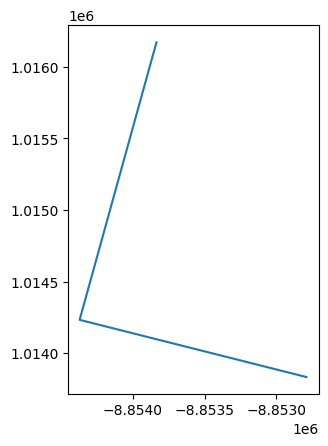

In [58]:
node_to_road_mapping[node_to_road_mapping[con.ID] == location_id]

node_to_road_mapping[node_to_road_mapping.road_index == 60415]

roads.loc[[60415]].plot()

#roads.reset_index().to_file("temp")

In [ ]:

# Converts to usual
roads[con.GEOMETRY] = roads[con.GEOMETRY].to_crs(con.USUAL_PROJECTION)

# Constructs edges
dfs = []
for r in node_to_road_mapping.road_index.unique():

    # Extracts the group
    node_group = node_to_road_mapping[node_to_road_mapping.road_index == r][[con.ID]]
    df = node_group.merge(node_group, how='cross')
    df = df[df.id_x > df.id_y].copy()
    df = df.rename(columns = {"id_x": con.NODE_ID1, "id_y": con.NODE_ID2})

    # Assigns value and geometry
    df[con.VALUE] = 1
    df[con.GEOMETRY] = roads.geometry.loc[r]

    dfs.append(df)

In [5]:
nodes = population_network.nodes

nodes

   Reading nodes from Cache


,id,lat,lon,population,geometry
0,Liberia - 0,10.633340,-85.436272,58725.820929,"MULTIPOLYGON (((-85.48115 10.56953, -85.48118 ..."
1,Tilarán - 1,10.470980,-84.967260,10366.156730,"MULTIPOLYGON (((-84.96930 10.46810, -84.96943 ..."
2,La Fortuna - 2,10.471684,-84.644436,1934.716064,"MULTIPOLYGON (((-84.64619 10.46981, -84.64616 ..."
3,Limón - 3,9.993560,-83.030314,19242.702255,"MULTIPOLYGON (((-83.03444 9.99205, -83.03437 9..."
4,Sixaola - 4,9.505422,-82.614567,1591.918549,"POLYGON ((-82.61344 9.50261, -82.61339 9.50246..."
...,...,...,...,...,...
6550,Bajo La Concepción - 6550,8.266004,-81.312094,275.206904,"POLYGON ((-81.29862 8.26600, -81.29868 8.26470..."
6551,Alto de La Palma - 6551,8.246557,-81.368233,314.413401,"POLYGON ((-81.35476 8.24656, -81.35482 8.24525..."
6552,Agua Viva - 6552,8.217208,-81.294220,300.897919,"POLYGON ((-81.28075 8.21721, -81.28081 8.21590..."
6553,El Bongo - 6553,7.920442,-80.462811,461.659553,"POLYGON ((-80.44650 7.91969, -80.44643 7.91971..."


AttributeError: module 'simulator.utils.geometric' has no attribute 'extract_city_centers_from_nodes'

In [9]:
available_edges

node_ids = pd.DataFrame({con.ID : nodes.index.values})
available_edges = node_ids.merge(node_ids, how = "cross")
available_edges = available_edges[available_edges[f"{con.ID}_x"] > available_edges[f"{con.ID}_y"]]

,id_x,id_y
6555,1,0
13110,2,0
13111,2,1
19665,3,0
19666,3,1
...,...,...
42968019,6554,6549
42968020,6554,6550
42968021,6554,6551
42968022,6554,6552


In [ ]:
# Create an undirected graph and finds connected components to merge
graph = nx.Graph()
graph.add_nodes_from(nodes.index.values)
graph.add_edges_from(intersection.apply(lambda row: (row.index_left, row.index_right), axis = 1).values)
components = list(nx.connected_components(graph))